In [20]:
# The usual import! 
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [3]:
# Read in the data and have a look
pulsar = pd.read_csv('/Users/Wag/Documents/Data Analytics/Kaggle/Pulsars/pulsar_stars.csv')
pulsar.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


The target_class column is the one of interest. A 1 means a confirmed pulsar. Taken from the Kaggle description:

"*Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve.*" 

A bit technical. But essentially a pulsar is a star that is spinning magnetized neutron star. It emits a beam of electromagnetic radiation and can be observed. The orientation, frequency of rotation, and several other specific characteristics are of both astrophysical and cosmological interest. Look up wikipedia, basically!

So the fascinating thing about pulsars is that their spin frequencies tell us things about the universe. This dataset appears to examine two key measurements: the '*integrated profile*' (IP for simplicity) and the '*DM-SNR*' curve.

I've never studied pulsars, but the former appears to be a measure of the 'regularity' of the characteristic rotation of each pulsar - from a quick google. Here is a typical example of an IP plotted:

<img src="IP1.png" alt="Drawing" style="width: 400px;"/>

Individual pulses seem to be somewhat stochastic, but the integrated - or summed - pulses over time appear to be quite regular and unique to the star.

So now we can conceptualise these IPs statistically, and get a feel for the standard deviation, excess kurtosis and skewness of the profile. It is probably a poor reference, but just for flavour the following are the properties of a standard univariate normal distribution: 

- 1 standard deviation =  68
- kurtosis (tail distribution) = 3
- skewness = 0

The latter, *DM-SNR*, is the 'Dispersion Measure Signal to Noise Ratio'. This measures the time dispersion of signals arriving at the detector due to atmospheric effects, interstellar dust, and other factors basically - I think! Then there is some SNR involved in the detection and the same measurements are applied, as above. 

Ok, with that out of the way, lets focus on some data analysis!

In [4]:
pulsar.shape # 17898 rows, 9 columns
pulsar.info() # No nulls?!..great!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 Mean of the integrated profile                  17898 non-null float64
 Standard deviation of the integrated profile    17898 non-null float64
 Excess kurtosis of the integrated profile       17898 non-null float64
 Skewness of the integrated profile              17898 non-null float64
 Mean of the DM-SNR curve                        17898 non-null float64
 Standard deviation of the DM-SNR curve          17898 non-null float64
 Excess kurtosis of the DM-SNR curve             17898 non-null float64
 Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


We can plot the histograms for each column and get a feel. First, change the column names first, as they are currently giving me finger cramps.

In [5]:
pulsar.columns = ['Mean_IP','SD_IP','Kurt_IP','Skew_IP','Mean_DM','SD_DM','Kurt_DM','Skew_DM','Class']
list(pulsar)

['Mean_IP',
 'SD_IP',
 'Kurt_IP',
 'Skew_IP',
 'Mean_DM',
 'SD_DM',
 'Kurt_DM',
 'Skew_DM',
 'Class']

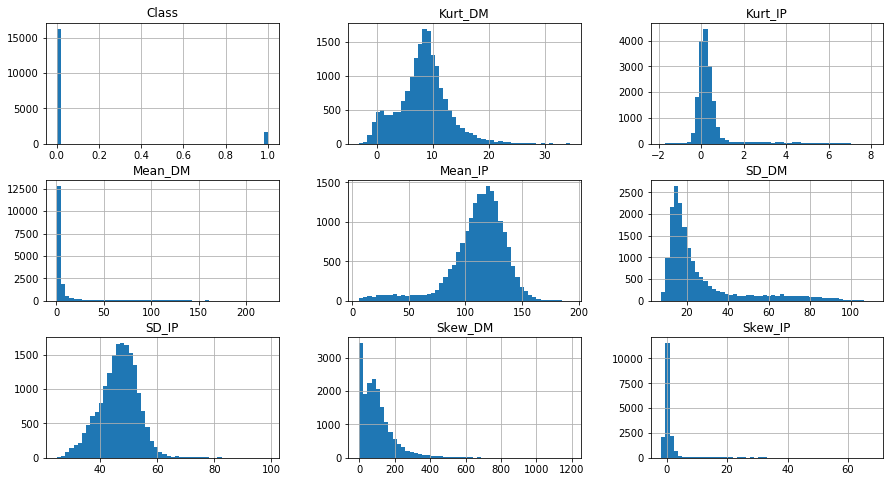

In [23]:
plt.rcParams['figure.figsize'] = [15, 8] # Controlling the size of the plot
plt.hist = pulsar.hist(bins=50)

Actually, the distribution of distributions (very meta) within the data don't appear to follow any clear cut general distribution (we wouldn't necessarily expect this). Perhaps a beta distribution, or a skewed normal, in some cases? Lets examine the key stats.

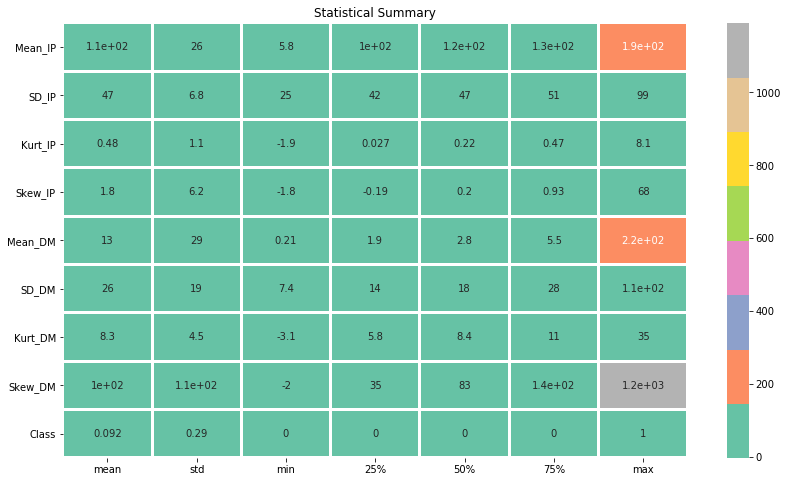

In [22]:
plt.figure(figsize=(14,8))
sns.heatmap(pulsar.describe()[1:].transpose(),
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Set2"))
plt.title("Statistical Summary")
plt.show()

We can try visually comparing some of the stats between pulsar and non-pulsar group.

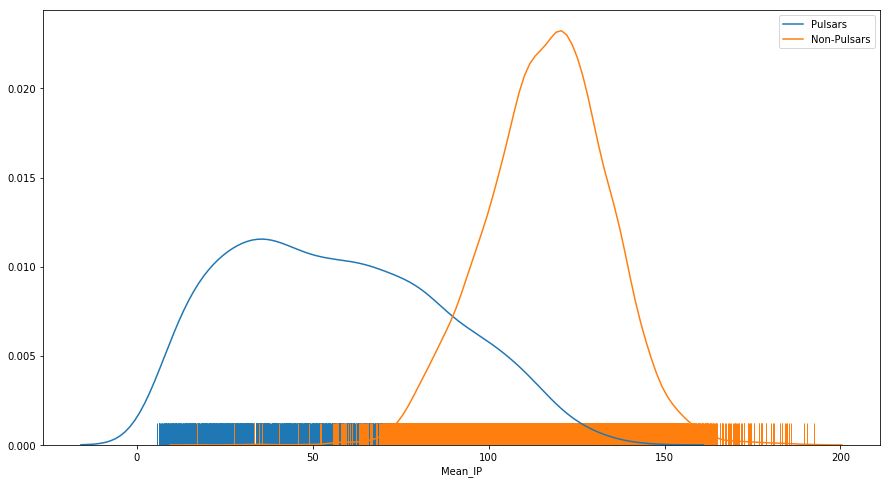

In [55]:
pulsars_yes = pulsar[pulsar['Class'] >= 1] # Excuse the basic naming!
pulsars_no = pulsar[pulsar['Class'] == 0]
sns.distplot(pulsars_yes.Mean_IP, hist=False, rug=True,label = 'Pulsars')
sns.distplot(pulsars_no.Mean_IP, hist=False, rug=True, label = 'Non-Pulsars')
plt.legend()
plt.show()

There does appear to be a significant difference here. The mean mean (not a typo) IP appear to be different for pulsars vs non-pulsars. Lets check out some another variable using the same idea.

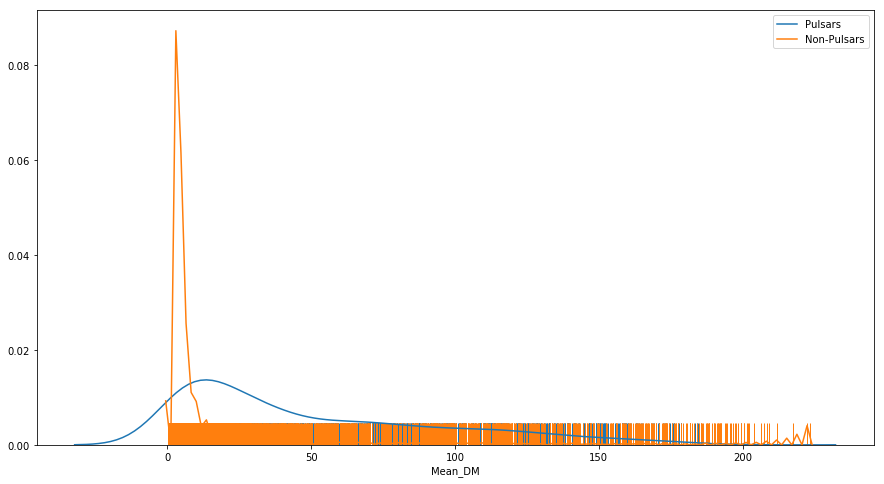

In [56]:
sns.distplot(pulsars_yes.Mean_DM, hist=False, rug=True,label = 'Pulsars')
sns.distplot(pulsars_no.Mean_DM, hist=False, rug=True, label = 'Non-Pulsars')
plt.legend()
plt.show()

Similarly, it is fair to say there is a difference, at least visually! We should probably look at this a bit more numerically and see if we can quantify this a bit. To be continued!